In [99]:
import pyodbc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

In [100]:
# Thông tin kết nối SQL Server
server = 'LAPTOP-GE6HN70J\SQLSERVER'  # Tên hoặc IP của SQL Server
database = 'Booking'  # Tên cơ sở dữ liệu

# Kết nối đến SQL Server bằng Windows Authentication
conn = pyodbc.connect(
    f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes;"
)

print("Kết nối thành công đến SQL Server!")

Kết nối thành công đến SQL Server!


In [101]:
# Truy vấn dữ liệu từ các bảng
query_review = "SELECT * FROM Review"
query_hotel = "SELECT * FROM Hotel"
query_city = "SELECT * FROM City"

# Đọc dữ liệu từ SQL Server
reviews = pd.read_sql(query_review, conn)
hotels = pd.read_sql(query_hotel, conn)
cities = pd.read_sql(query_city, conn)

# Kiểm tra dữ liệu
print(reviews.head())
print(hotels.head())
print(cities.head())

   ReviewID  Score  ReviewsCount  AvgReview  Facilities  Comfort  Staff  \
0         1    7.0             3        Tốt         6.7      5.8    6.7   
1         2    8.1            44    Rất tốt         8.2      8.2    8.7   
2         3    8.8           303  Tuyệt vời         8.8      9.0    9.1   
3         4    8.0            24    Rất tốt         8.1      7.8    8.5   
4         5    8.9           117  Tuyệt vời         9.0      9.2    9.0   

   FreeWifi  ValueforMoney  Cleanliness  Location  ScrapeDate  HotelID  
0       7.0            5.8          6.7       6.7  2024-11-05        1  
1       8.6            8.0          8.2       8.8  2024-11-06        2  
2       8.8            9.2          9.0       8.7  2024-11-06        3  
3       8.0            8.1          8.4       9.0  2024-11-05        4  
4       7.5            9.3          9.1       9.3  2024-11-08        5  
   HotelID            HotelName    Price  CityID
0        1  !!! Amare Apartment  1000000      11
1        2   

C:\Users\Admin\AppData\Local\Temp\ipykernel_14524\1217101170.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  reviews = pd.read_sql(query_review, conn)
C:\Users\Admin\AppData\Local\Temp\ipykernel_14524\1217101170.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hotels = pd.read_sql(query_hotel, conn)
C:\Users\Admin\AppData\Local\Temp\ipykernel_14524\1217101170.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cities = pd.read_sql(query_city, conn)


In [102]:
# Ánh xạ thông tin từ bảng Hotel vào bảng Review
for col in hotels.columns:  # Lặp qua tất cả các cột trong bảng Hotel
    if col != 'HotelID':  # Tránh ánh xạ lại chính 'HotelID'
        reviews[col] = reviews['HotelID'].map(hotels.set_index('HotelID')[col].to_dict())

# Ánh xạ thông tin từ bảng City vào bảng Review thông qua CityID
for col in cities.columns:  # Lặp qua tất cả các cột trong bảng City
    if col != 'CityID':  # Tránh ánh xạ lại chính 'CityID'
        reviews[col] = reviews['CityID'].map(cities.set_index('CityID')[col].to_dict())

# Kiểm tra kết quả
print(reviews.head())

   ReviewID  Score  ReviewsCount  AvgReview  Facilities  Comfort  Staff  \
0         1    7.0             3        Tốt         6.7      5.8    6.7   
1         2    8.1            44    Rất tốt         8.2      8.2    8.7   
2         3    8.8           303  Tuyệt vời         8.8      9.0    9.1   
3         4    8.0            24    Rất tốt         8.1      7.8    8.5   
4         5    8.9           117  Tuyệt vời         9.0      9.2    9.0   

   FreeWifi  ValueforMoney  Cleanliness  Location  ScrapeDate  HotelID  \
0       7.0            5.8          6.7       6.7  2024-11-05        1   
1       8.6            8.0          8.2       8.8  2024-11-06        2   
2       8.8            9.2          9.0       8.7  2024-11-06        3   
3       8.0            8.1          8.4       9.0  2024-11-05        4   
4       7.5            9.3          9.1       9.3  2024-11-08        5   

             HotelName    Price  CityID               City  
0  !!! Amare Apartment  1000000      11    

In [103]:
# Xóa các cột không cần thiết
columns_to_drop = ['HotelID', 'CityID', 'ReviewID', 'HotelName', 'ScrapeDate', 'Facilities', 'AvgReview' , 'Comfort', 'Staff', 'FreeWifi', 'ValueforMoney', 'Cleanliness', 'Location', 'City' ] 
reviews = reviews.drop(columns=columns_to_drop, errors='ignore')

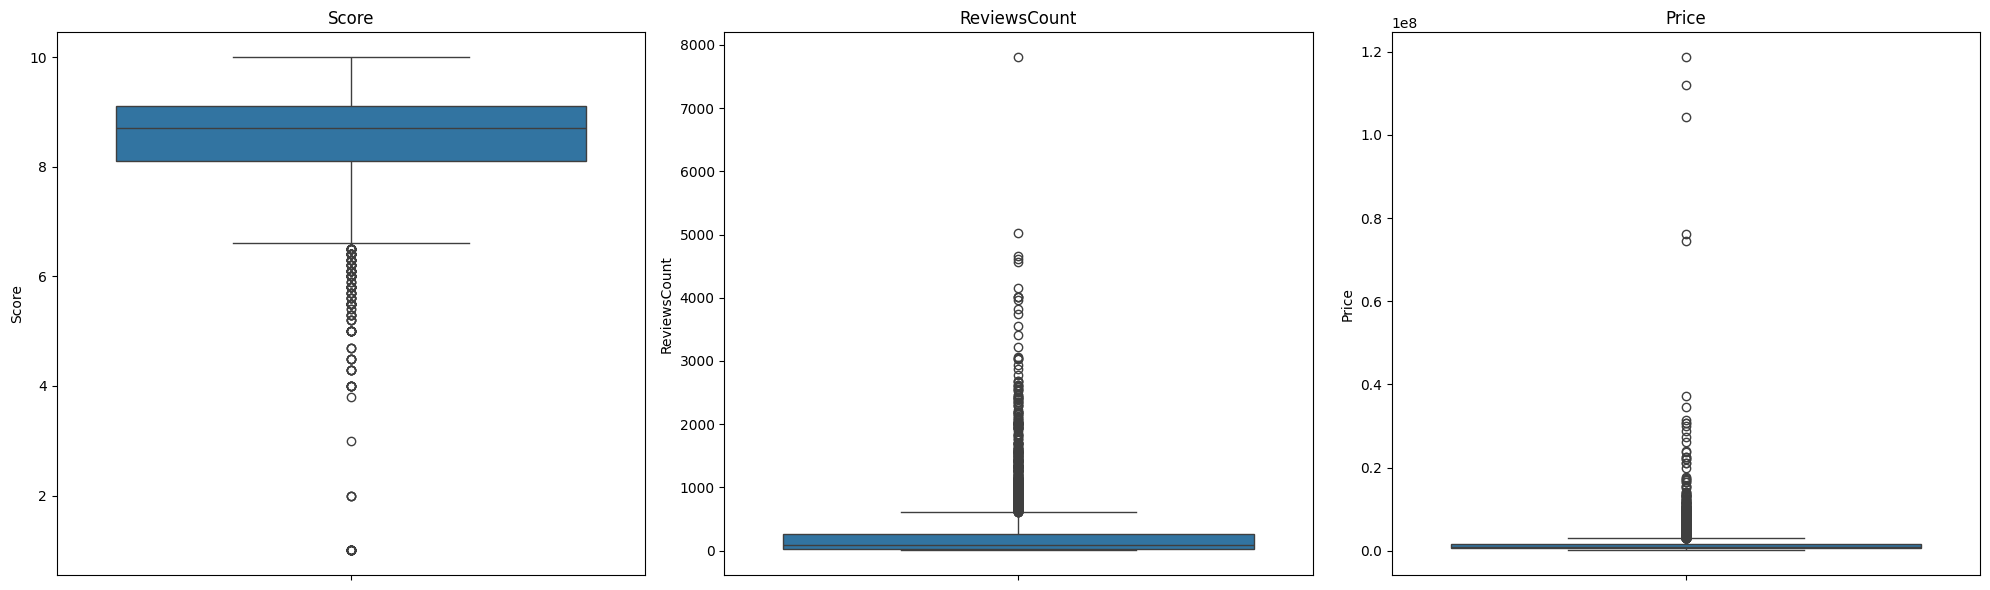

In [104]:
# Lọc những cột có kiểu dữ liệu số
numeric_columns = reviews.select_dtypes(include=['number']).columns

# Tạo một hình vẽ cho mỗi cột số
plt.figure(figsize=(20, 6))

# Vẽ từng box plot cho mỗi cột số
for i, column in enumerate(numeric_columns):
    plt.subplot(1, len(numeric_columns), i + 1)  # Sắp xếp các box plot theo hàng
    sns.boxplot(data=reviews[column])
    plt.title(f'{column}')
    plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

In [105]:
# Áp dụng StandardScaler cho toàn bộ dữ liệu
scaler = StandardScaler()
scaled_data = scaler.fit_transform(reviews)

# Chuyển dữ liệu đã scale thành DataFrame
reviews_scaled = pd.DataFrame(scaled_data, columns=reviews.columns)

# Kiểm tra dữ liệu sau khi scale
print(reviews_scaled.describe())

              Score  ReviewsCount         Price
count  6.370000e+03  6.370000e+03  6.370000e+03
mean  -1.290578e-15 -4.461807e-18 -2.900174e-17
std    1.000079e+00  1.000079e+00  1.000079e+00
min   -7.693138e+00 -5.620453e-01 -4.271696e-01
25%   -4.307918e-01 -5.008223e-01 -2.805652e-01
50%    1.829276e-01 -3.391936e-01 -1.801920e-01
75%    5.920738e-01  7.406178e-02 -5.317100e-03
max    1.512653e+00  1.855913e+01  3.366361e+01


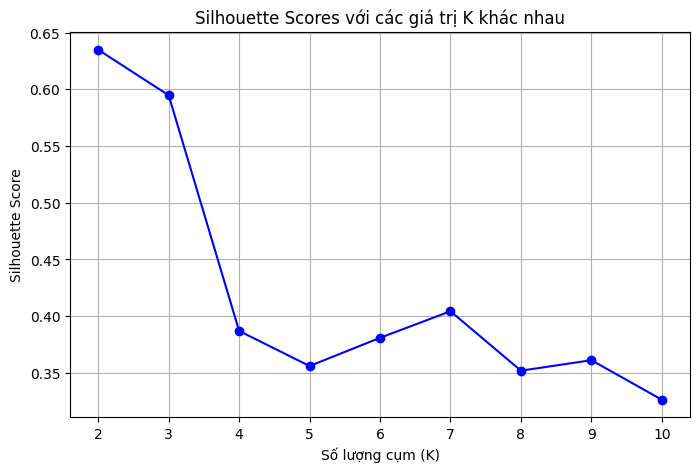

Số lượng cụm tối ưu (K): 2


In [106]:
# Danh sách lưu Silhouette Score cho mỗi số cụm K
silhouette_scores = []

# Thử với các giá trị K từ 2 đến 10 
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(reviews_scaled)  # Phân cụm
    score = silhouette_score(reviews_scaled, clusters)  # Tính Silhouette Score
    silhouette_scores.append(score)

# Vẽ biểu đồ Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Scores với các giá trị K khác nhau')
plt.xlabel('Số lượng cụm (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# In ra kết quả
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Số lượng cụm tối ưu (K): {optimal_k}")


In [107]:
# Xây dựng mô hình K-means với số cụm tối ưu
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(reviews_scaled)
reviews_scaled['Cluster'] = clusters
# Silhouette score: Đánh giá mức độ phân tách của các cụm
silhouette_avg = silhouette_score(reviews_scaled, reviews_scaled['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.650229151859568


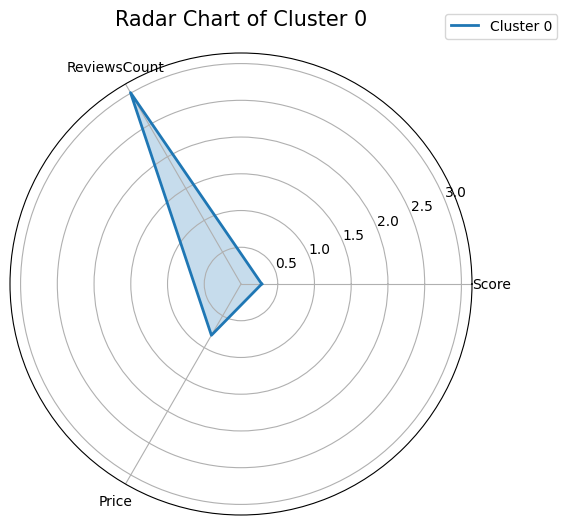

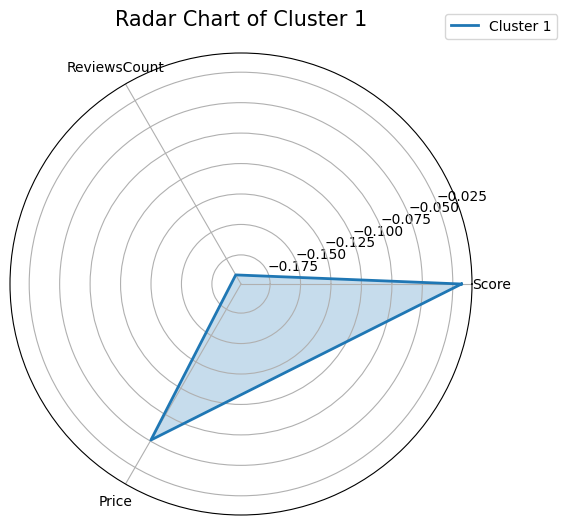

In [114]:
labels = reviews.columns.tolist()[:3] 
num_vars = len(labels) 

# Lấy các tâm cụm (centroids) từ mô hình K-means
centroids = kmeans.cluster_centers_

# Tính các góc cho biểu đồ radar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Đóng vòng tròn để kết nối điểm đầu và cuối

# Vẽ một biểu đồ radar cho mỗi cụm
for i, cluster in enumerate(centroids):
    # Tạo figure cho mỗi cụm
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    # Lấy giá trị cho tâm cụm và đóng vòng tròn
    values = cluster[:num_vars].tolist()
    values += values[:1]  # Đóng vòng tròn

    # Vẽ đồ thị radar cho mỗi cụm
    ax.plot(angles, values, label=f'Cluster {i}', linewidth=2)
    ax.fill(angles, values, alpha=0.25)

    # Tùy chỉnh trục và nhãn
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)  
    ax.set_title(f'Radar Chart of Cluster {i}', size=15, pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))  # Hiển thị chú thích

    # Hiển thị biểu đồ cho từng cụm
    plt.show()

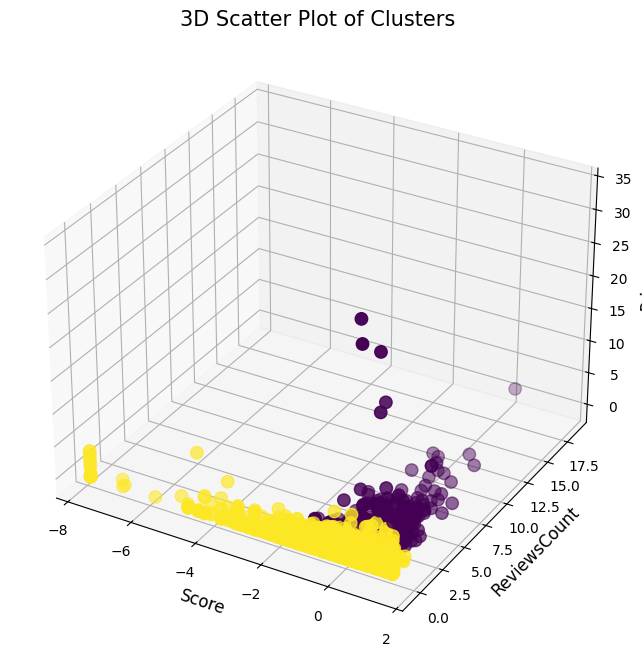

In [111]:
# Tạo biểu đồ 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = reviews_scaled['Score']          # Trục X
y = reviews_scaled['ReviewsCount']   # Trục Y
z = reviews_scaled['Price']          # Trục Z

# Nhãn cụm từ mô hình K-means
clusters = reviews_scaled['Cluster']

# Vẽ biểu đồ scatter plot 3D với các cụm
ax.scatter(x, y, z, c=clusters, cmap='viridis', s=80)

# Đặt tiêu đề và nhãn cho từng trục
ax.set_title('3D Scatter Plot of Clusters', fontsize=15)
ax.set_xlabel('Score', fontsize=12)
ax.set_ylabel('ReviewsCount', fontsize=12)
ax.set_zlabel('Price', fontsize=12)  

# Hiển thị biểu đồ
plt.show()